# Generative Adversarial Networks
You should build an end-to-end machine learning pipeline using a generative adversarial network model. In particular, you should do the following:
- Load the `mnist` dataset using [Pandas](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html). You can find this dataset in the [TensorFlow repository](https://www.tensorflow.org/tutorials/generative/dcgan).
- Build an end-to-end machine learning pipeline, including a [generative adversarial network](https://www.tensorflow.org/tutorials/generative/dcgan) model.
- Optimize your pipeline by validating your design decisions.
- Generate new images using your trained generator model and inspect the results.  
- Check the documentation to identify the most important hyperparameters, attributes, and methods of the model. Use them in practice.

In [14]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from IPython import display

tf.random.set_seed(42)
np.random.seed(42)

Loading and Preprocessing the Data

In [15]:
# 1. Load the data
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

# 2. FILTER: Select only images where the label is 3
# The labels are just an array of numbers. We create a mask where label == 3.
class_to_keep = 3
train_images = train_images[train_labels == class_to_keep]

# Optional: Print to verify we have fewer images now
print(f"Number of images in class {class_to_keep}: {train_images.shape[0]}")

# 3. Preprocess as normal
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32")
train_images = (train_images - 127.5) / 127.5

# 4. Batch and Buffer
BATCH_SIZE = 256
# Buffer size is smaller now (approx 6,000 images instead of 60,000)
BUFFER_SIZE = train_images.shape[0]

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Number of images in class 3: 6131


Define the Generator Model

In [16]:
NOISE_DIM = 100

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(NOISE_DIM,)))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding="same", use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same", use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding="same", use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Initialize and Test Generator

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


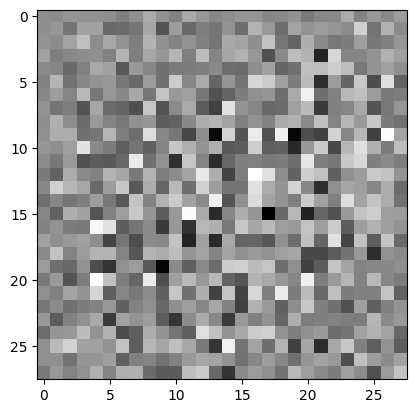

In [17]:
generator = make_generator_model()

noise = tf.random.normal([1, NOISE_DIM])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap="gray")

Define the Discriminator Model

In [18]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding="same", input_shape=[28, 28, 1]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))

    return model

discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.0006444]], shape=(1, 1), dtype=float32)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Defining the Loss and Optimizers

In [19]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

Defining the Training Step

In [20]:
# Notice the use of `tf.function`. This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

Execution of Training Loop

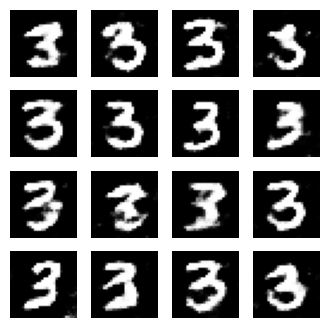

In [21]:
EPOCHS = 100
NUM_EXAMPLES_TO_GENERATE = 16
NOISE_DIM = 100
seed = tf.random.normal([NUM_EXAMPLES_TO_GENERATE, NOISE_DIM])

# Create the tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

for epoch in range(EPOCHS):
    # Training Loop
    for image_batch in train_dataset:
        train_step(image_batch)

    # Generate and display images
    display.clear_output(wait=True)
    predictions = generator(seed, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap="gray")
        plt.axis("off")
    plt.show()

Generating New Images (Inference)

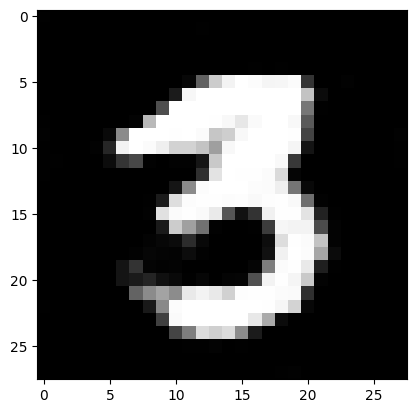

In [22]:
# Generating New Images

noise = tf.random.normal([1, NOISE_DIM])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap="gray")